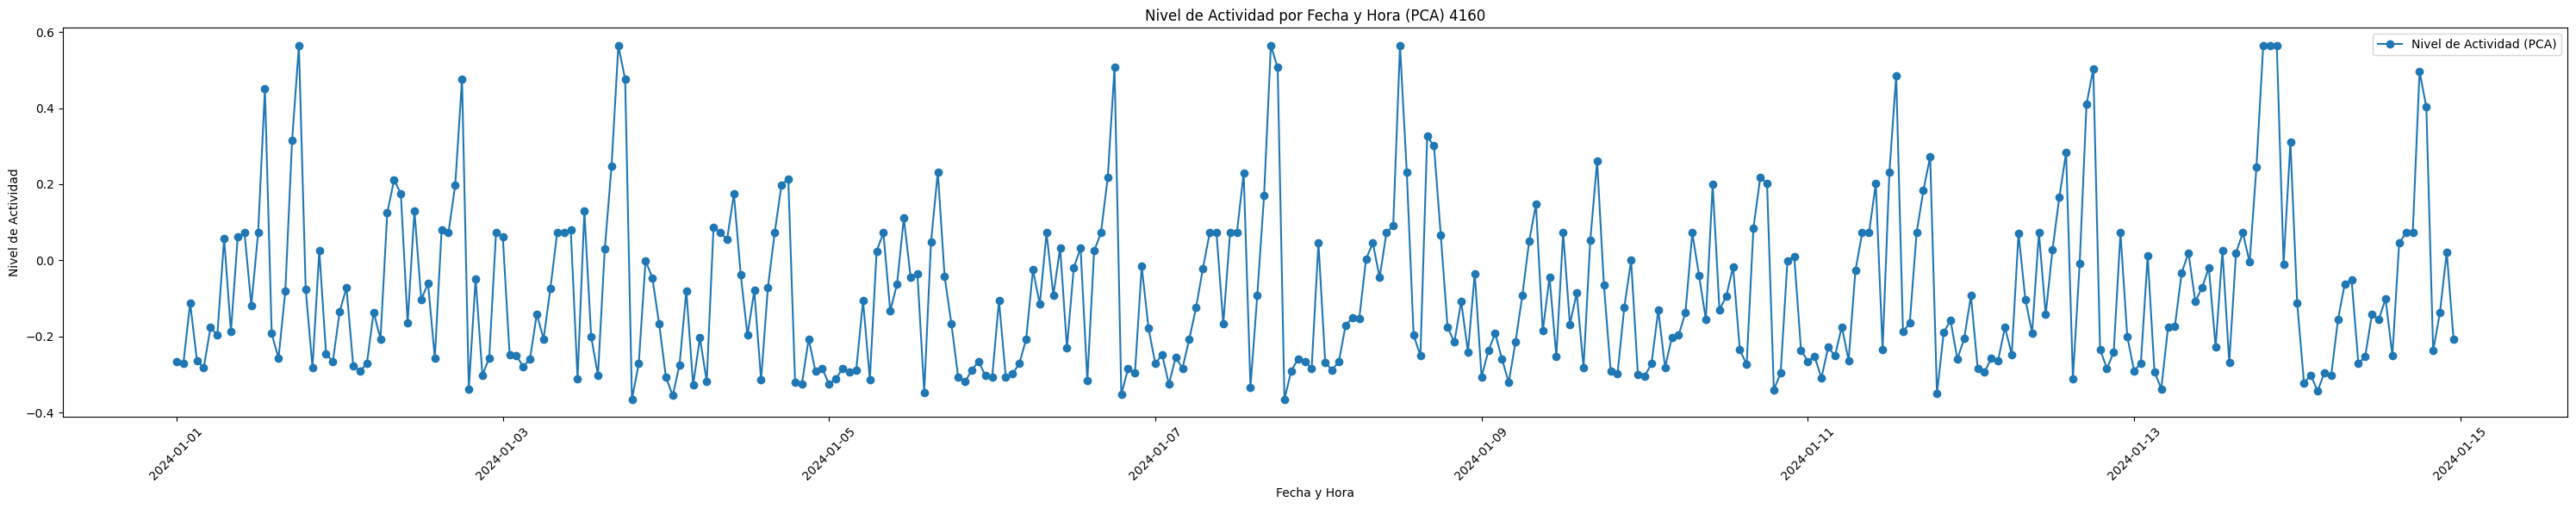

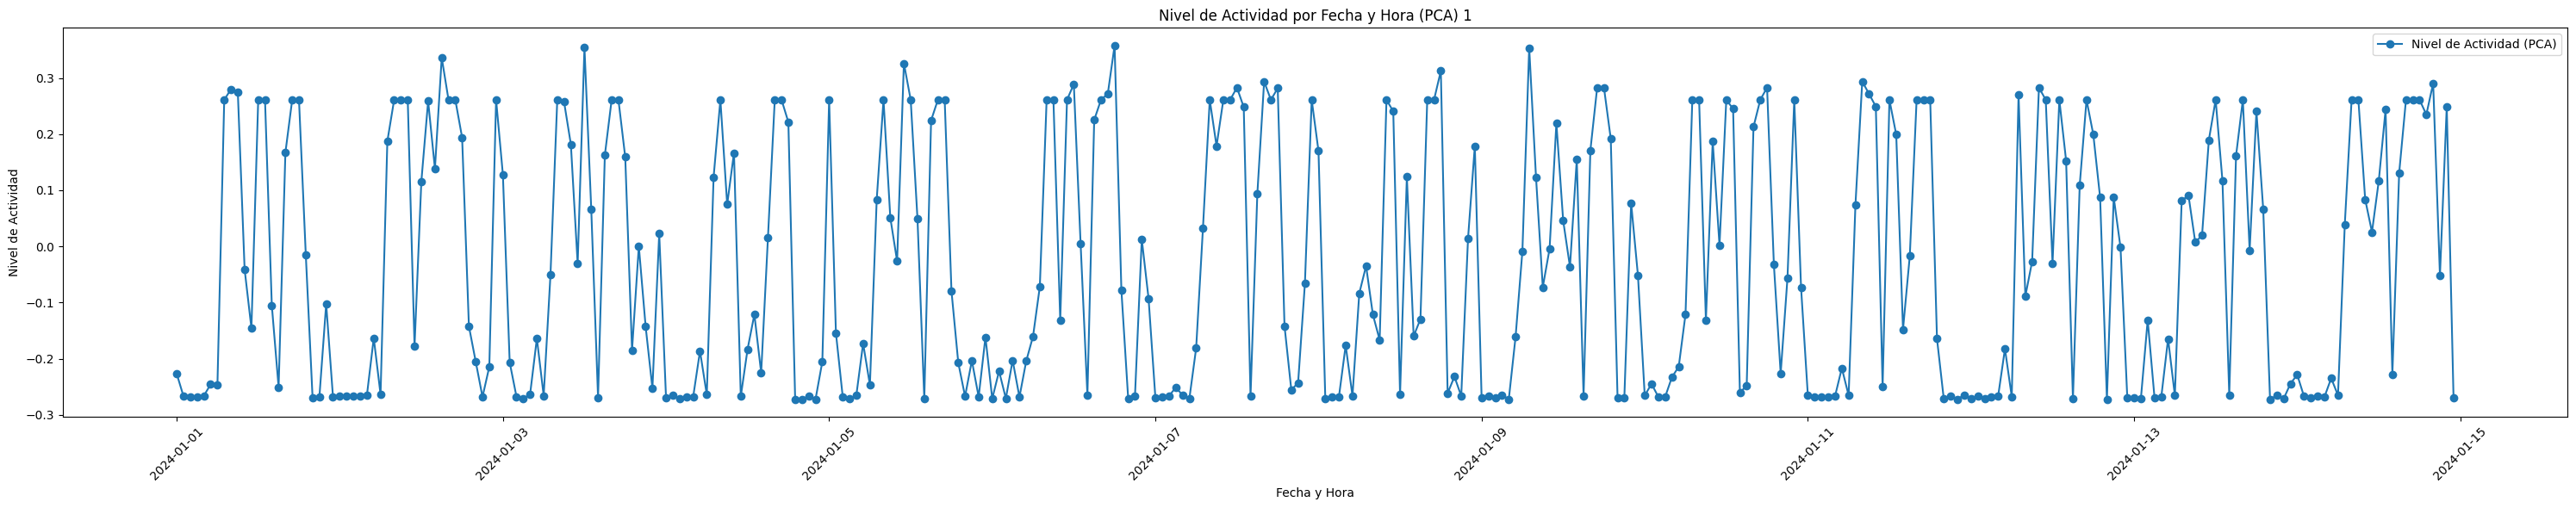

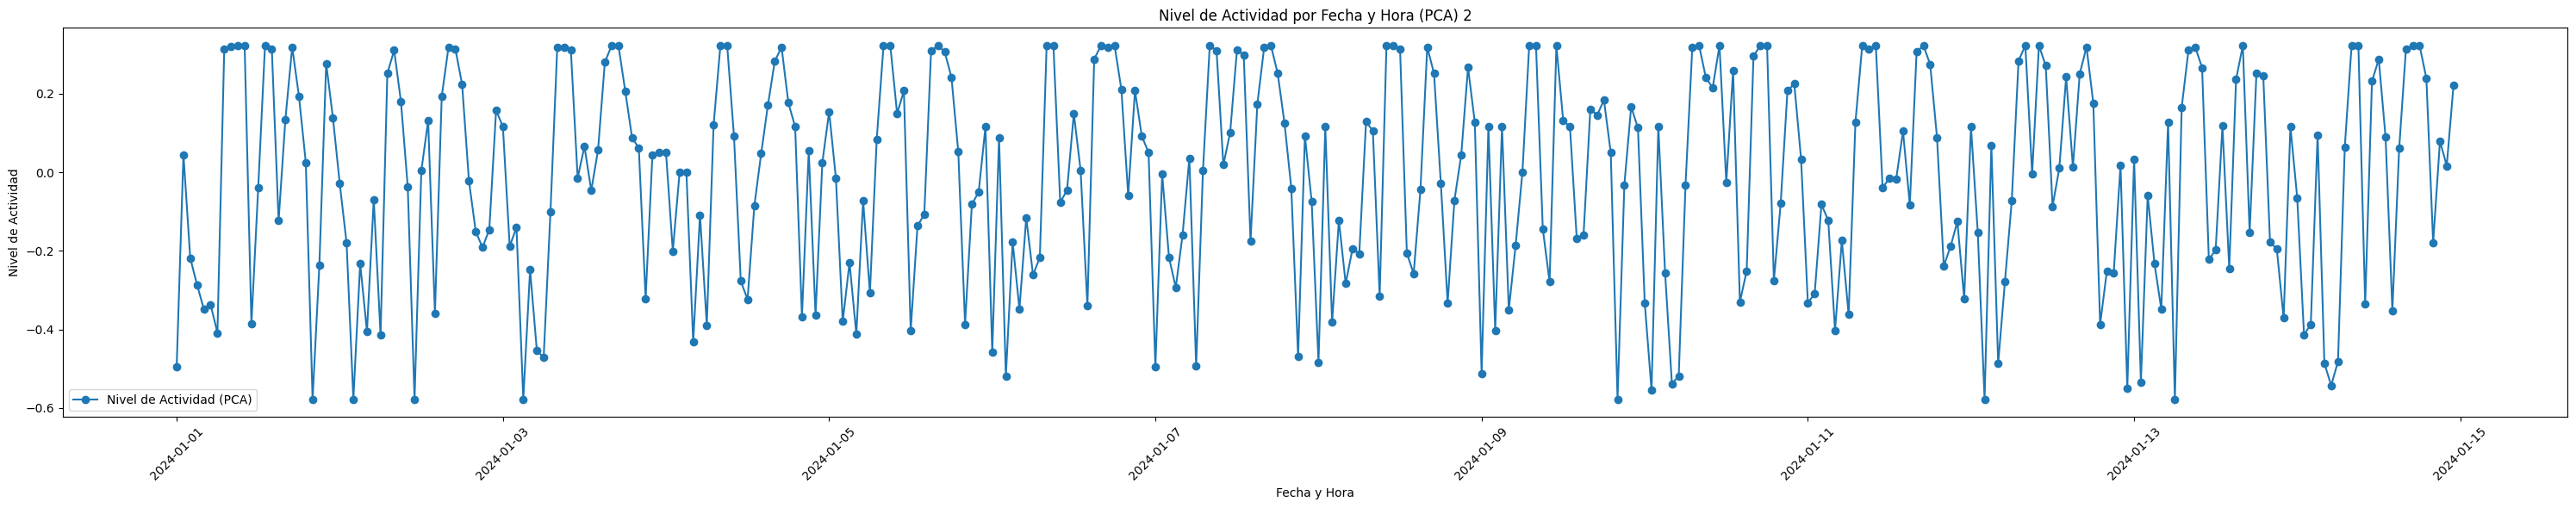

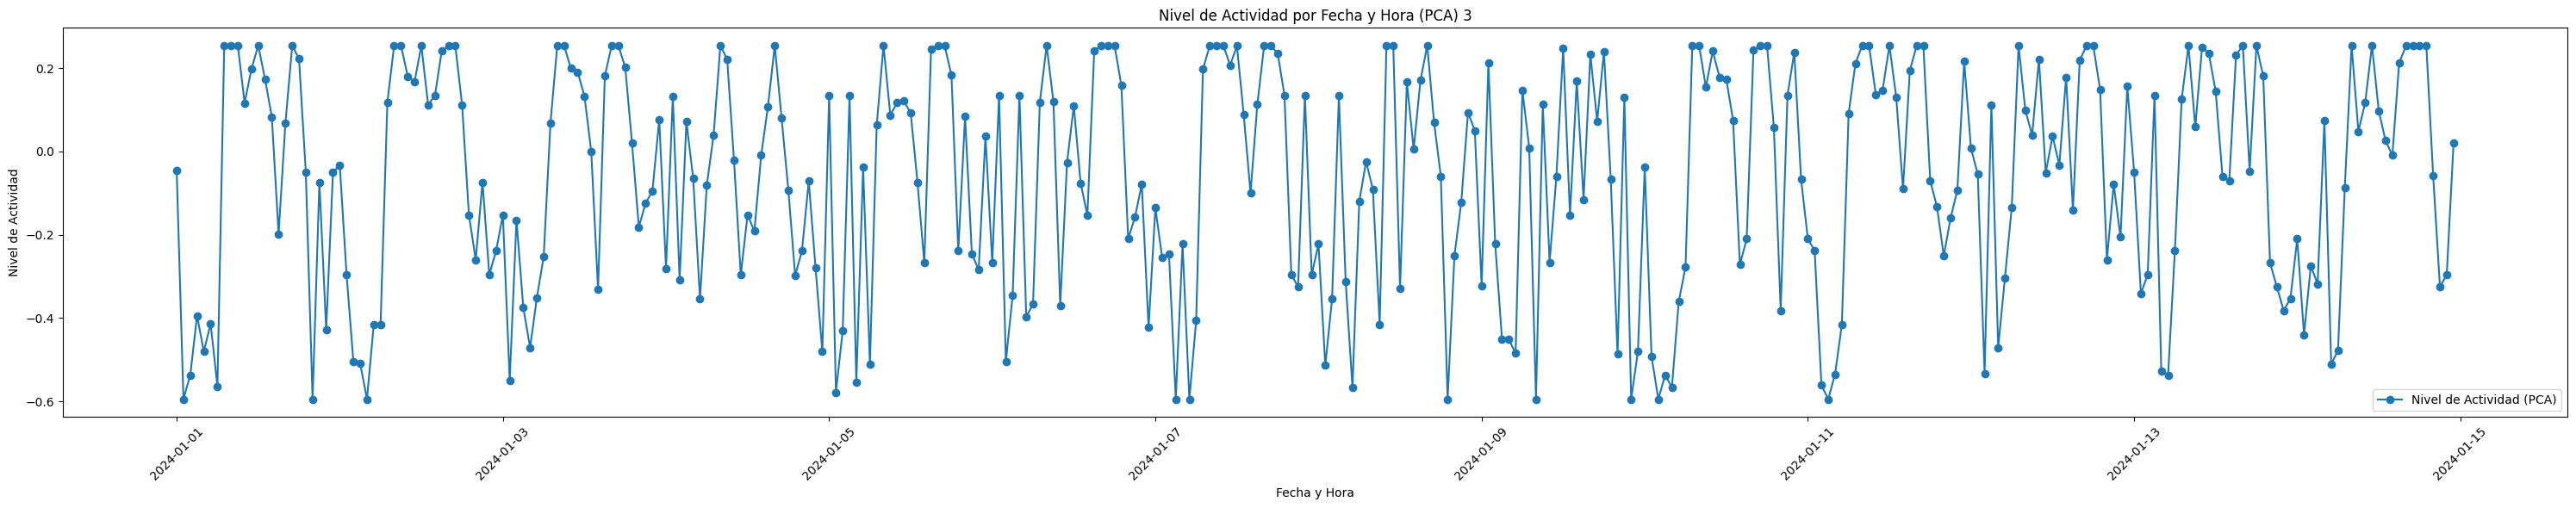

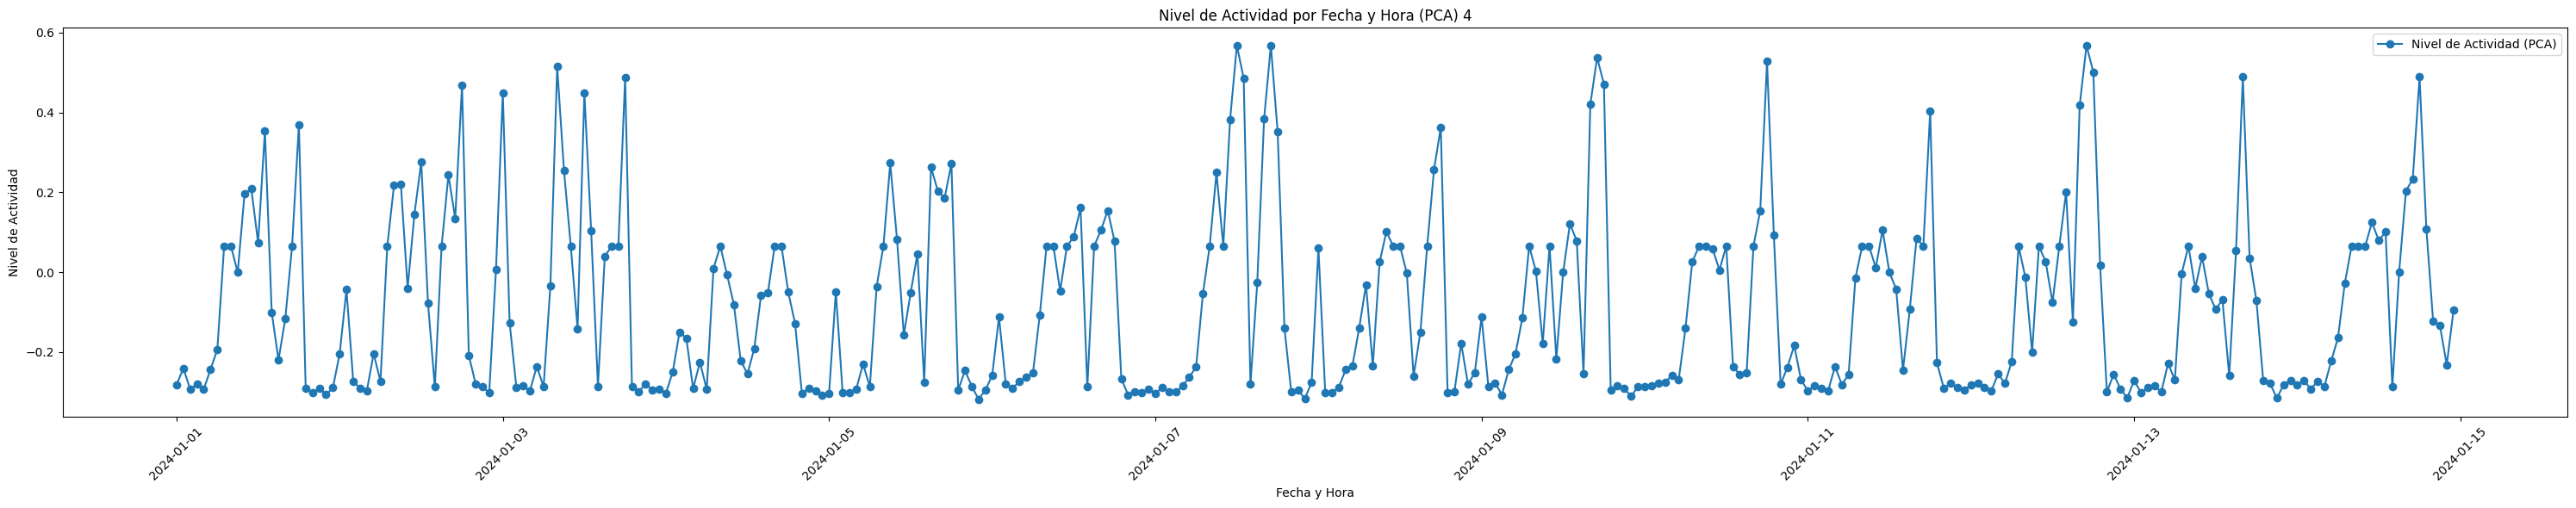

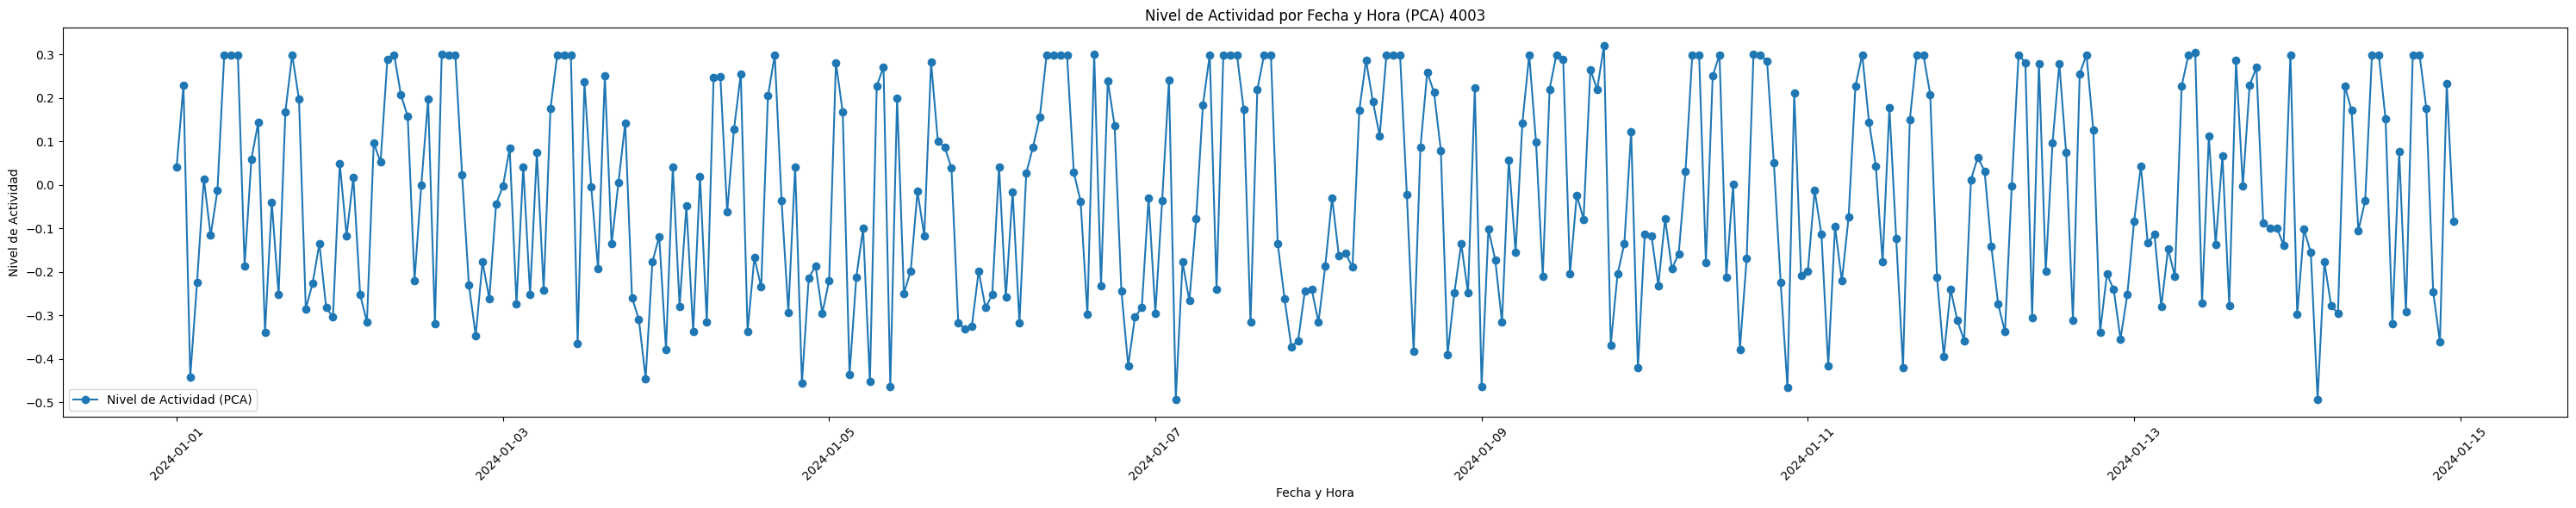

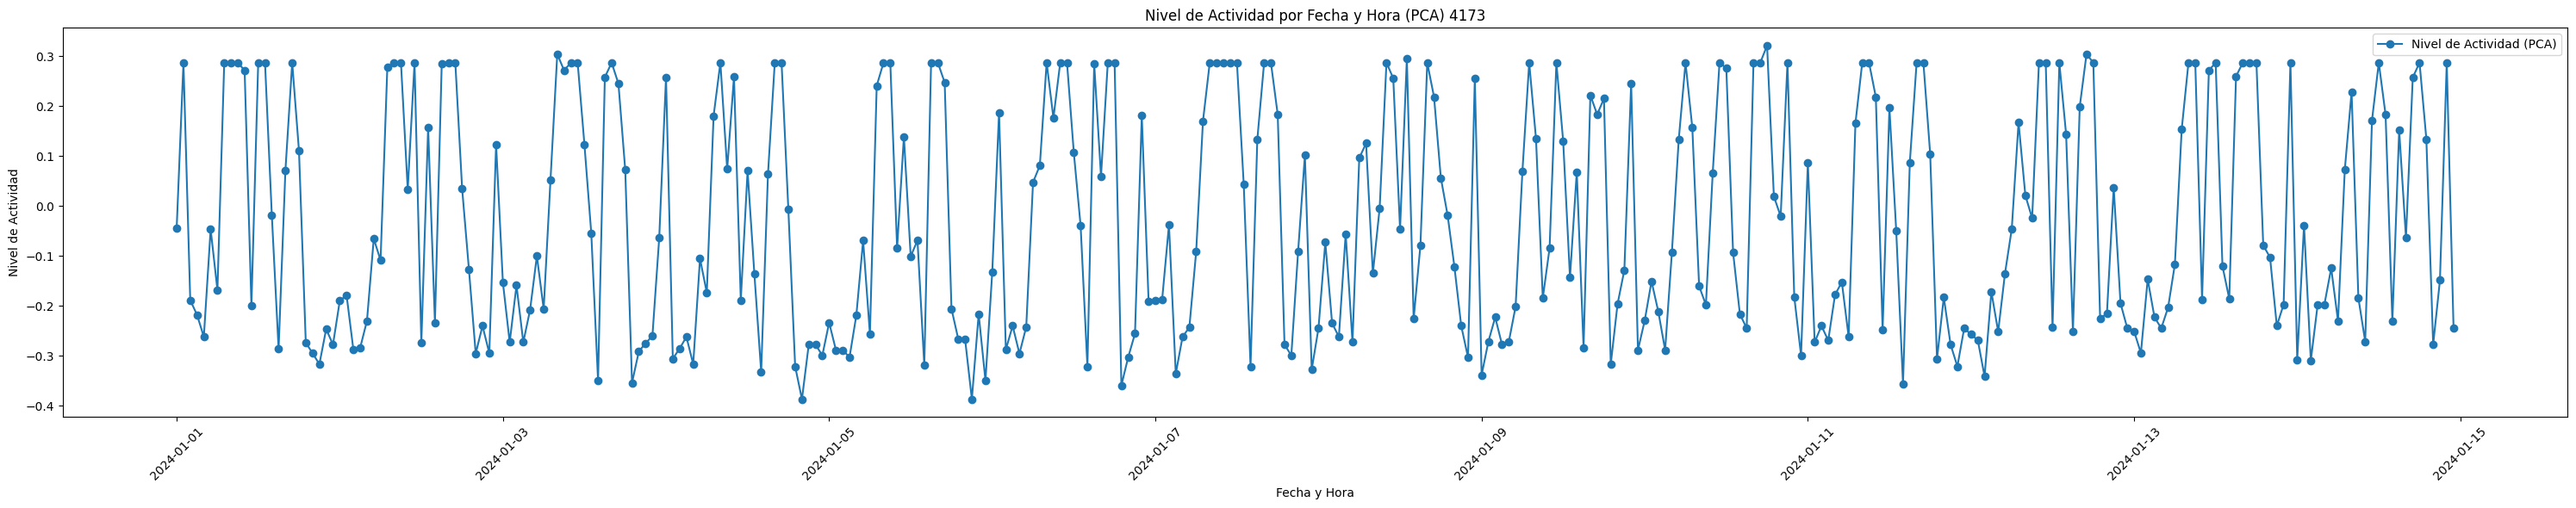

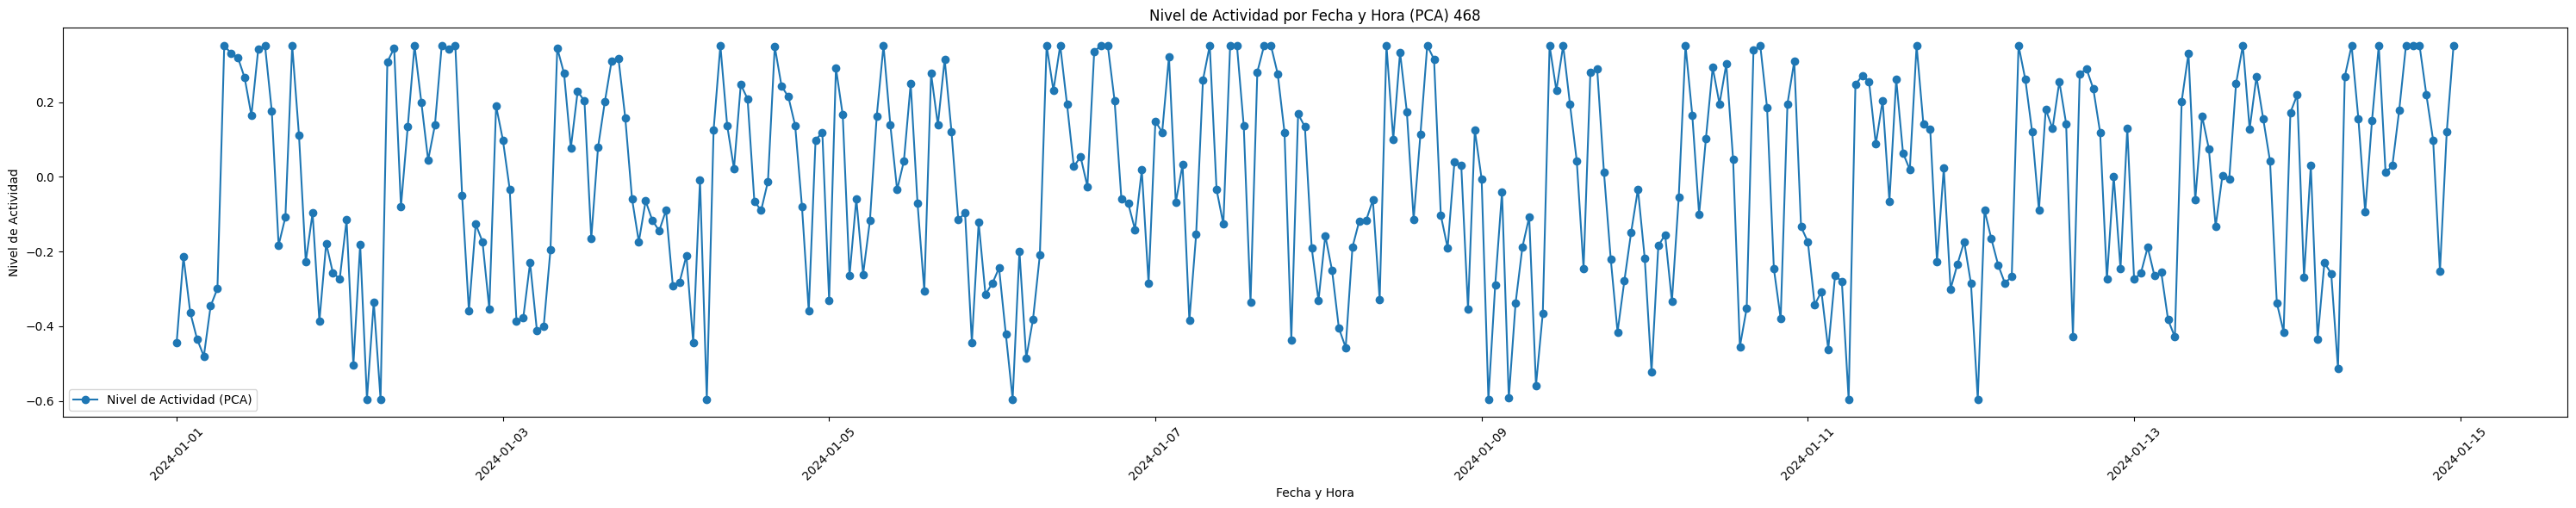

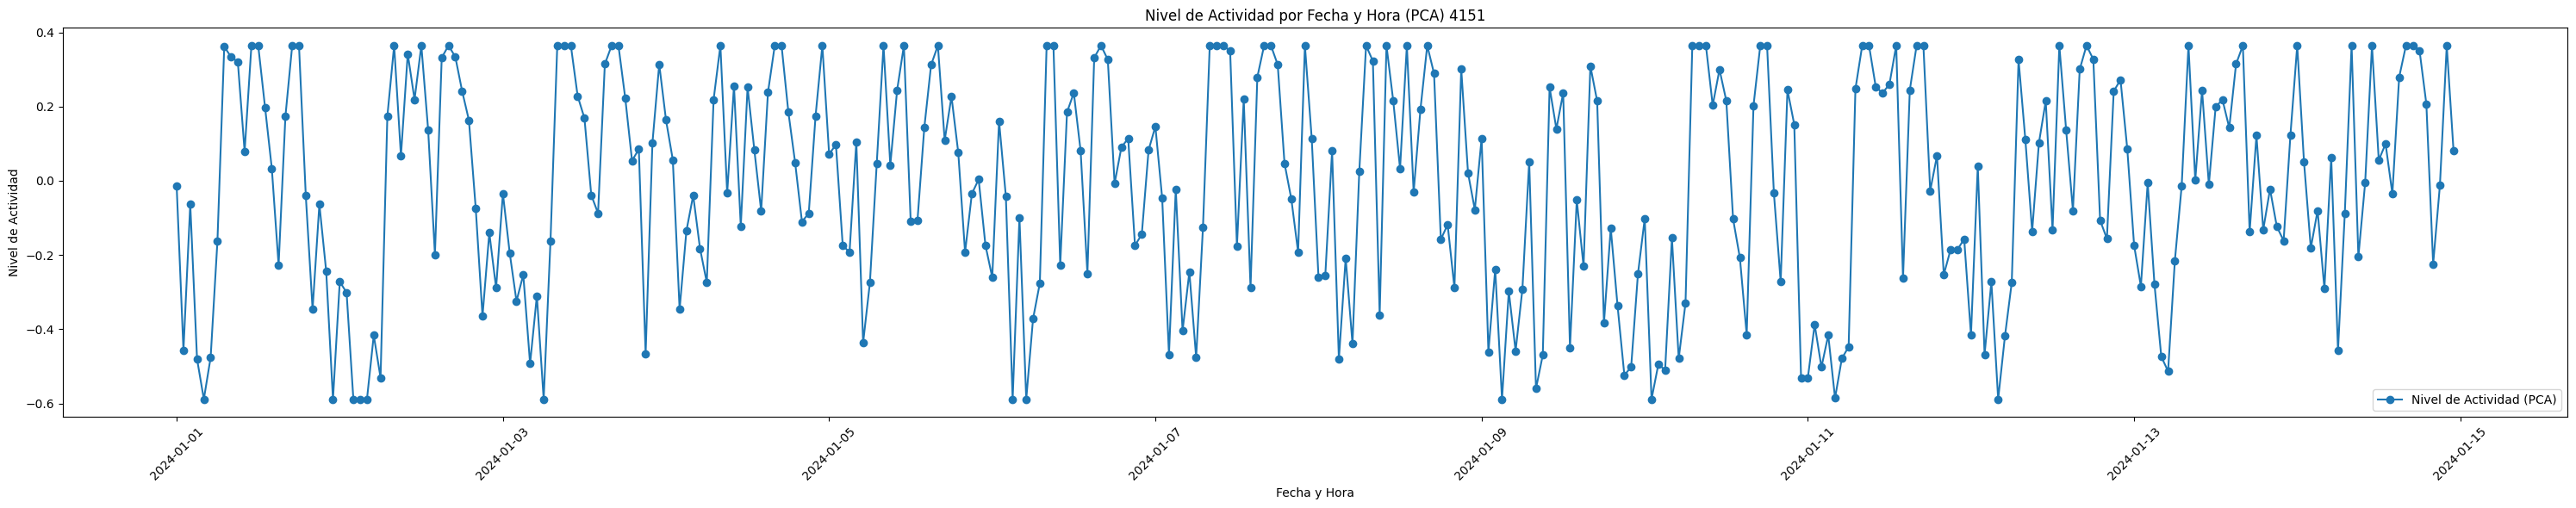

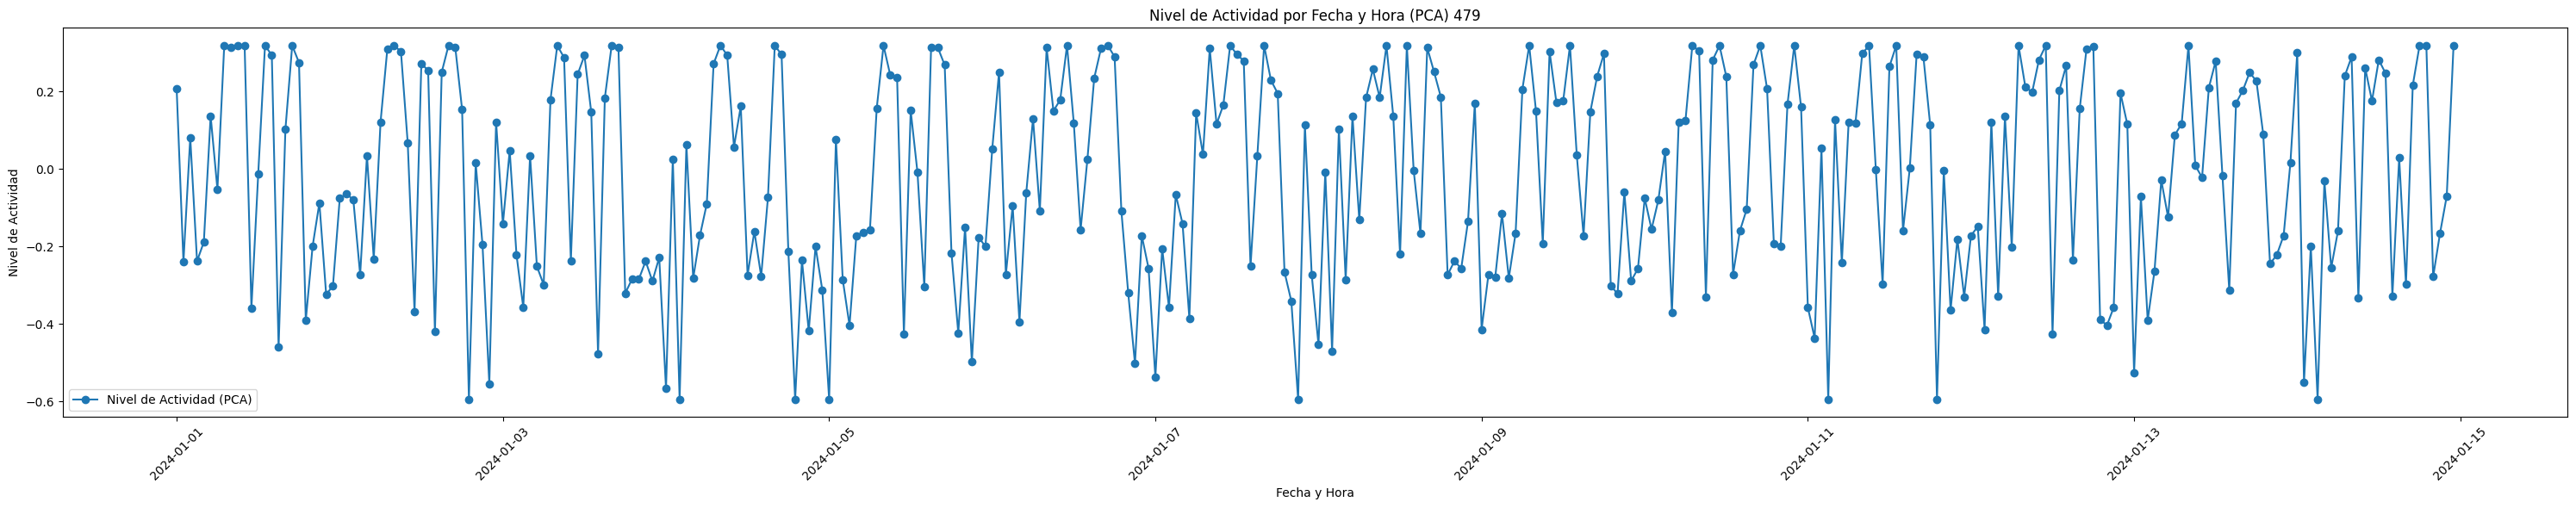

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import joblib
import prince  # Necesario para el análisis de correspondencias

# Cargar los datos
nombres_csv = {1,2,3,4,468,479,4003,4151,4160,4173}
pca_pesos={}

for nombre_csv in nombres_csv:
    data = pd.read_csv(f'Datos_procesados/{nombre_csv}.csv')
    data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir 'Fecha' a formato datetime
    #ata_periods =data[['period eating', 'period other', 'period resting', 'period rumination']]
    # Definir la fecha límite y filtrar el DataFrame
    fecha_limite = '2024-01-14'
    df_14days = data[data['Fecha'] <= fecha_limite].copy()

    # Normalizar los datos para PCA (sin 'Fecha' y 'Hora')
    scaler = StandardScaler()
    #scaler = MinMaxScaler(feature_range = (0,1))
    continue_data = df_14days[['period eating', 'period other', 'period resting', 'period rumination']]
    #data_periods_scaled = scaler.fit_transform(data_periods)
    continue_data_scaled = scaler.fit_transform(continue_data)
    # guardar estandarización
    #joblib.dump(scaler, f'scalers/{nombre_csv}_scaler.pkl')
    
    # PCA (Análisis de Componentes Principales):
    # Se aplica a datos cuantitativos (variables numéricas continuas).
    # Busca encontrar combinaciones lineales de variables originales para explicar la mayor varianza posible.
    # AFC (Análisis Factorial de Correspondencias):
    # Se aplica a datos categóricos (tablas de contingencia o frecuencias).
    # Sirve para analizar la relación entre dos o más variables categóricas
    
    # Aplicar PCA para análisis de actividad
    pca = PCA(n_components=2)
    components = pca.fit_transform(continue_data_scaled)

    # Crear un DataFrame para los componentes principales
    loadings = pca.components_.T
    loadings_continue_data = pd.DataFrame(data=loadings, index=continue_data.columns, columns=['Principal Component 1', 'Principal Component 2'])

    # Calcular los pesos y el nivel de actividad basado en PCA
    pca_weights = (loadings_continue_data['Principal Component 1'] + loadings_continue_data['Principal Component 2']) / 2
    pca_pesos[nombre_csv]=pca_weights
    activity_level = continue_data.dot(pca_weights)
    # Añadir el nivel de actividad basado en PCA al DataFrame filtrado
    df_14days['nivel_actividad'] = activity_level

    # Calcular y añadir el nivel de actividad (PCA) al DataFrame original `data`
    data_continue = data[['period eating', 'period other', 'period resting', 'period rumination']]
    data['nivel_actividad'] = data_continue.dot(pca_weights)


    data.to_csv(f'Datos_actividad/{nombre_csv}_act.csv', index=False)
    
    # Crear la columna datetime combinando 'Fecha' y 'Hora'
    df_14days['FechaHora'] = df_14days.apply(lambda row: pd.Timestamp(row['Fecha']) + pd.Timedelta(hours=row['Hora']), axis=1)

    # Asegurarse de que los datos estén ordenados por 'FechaHora'
    df_14days.sort_values('FechaHora', inplace=True)

    # Visualizar los resultados de PCAcomo gráficos de líneas
    plt.figure(figsize=(30, 6))
    plt.plot(df_14days['FechaHora'], df_14days['nivel_actividad'], marker='o', label='Nivel de Actividad (PCA)')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Nivel de Actividad')
    plt.title(f'Nivel de Actividad por Fecha y Hora (PCA) {nombre_csv}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:
# Crear la columna datetime combinando 'Fecha' y 'Hora'
# df_14days['FechaHora'] = df_14days.apply(lambda row: pd.Timestamp(row['Fecha']) + pd.Timedelta(hours=row['Hora']), axis=1)

# # Asegurarse de que los datos estén ordenados por 'FechaHora'
# df_14days.sort_values('FechaHora', inplace=True)

# # Visualizar los resultados de PCA y AFC como gráficos de líneas
# plt.figure(figsize=(30, 6))
# plt.plot(df_14days['FechaHora'], df_14days['nivel_actividad'], marker='o', label='Nivel de Actividad (PCA)')
# plt.xlabel('Fecha y Hora')
# plt.ylabel('Nivel de Actividad')
# plt.title('Nivel de Actividad por Fecha y Hora (PCA y AFC)')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [16]:
# Combina las Series en un DataFrame
pssa = pd.DataFrame.from_dict(pca_pesos, orient="index")

# Guarda el DataFrame en un archivo CSV
pssa.to_csv("pesos_actividad/data.csv", index_label="id")

In [19]:
pca_pesos

{4160: period eating        0.072168
 period other         0.564514
 period resting      -0.206556
 period rumination   -0.365309
 dtype: float64,
 1: period eating        0.261201
 period other         0.536791
 period resting      -0.263668
 period rumination   -0.272229
 dtype: float64,
 2: period eating        0.322987
 period other         0.220680
 period resting      -0.577493
 period rumination    0.116110
 dtype: float64,
 3: period eating        0.254034
 period other         0.253133
 period resting      -0.594527
 period rumination    0.133896
 dtype: float64,
 4: period eating        0.065421
 period other         0.567442
 period resting      -0.269643
 period rumination   -0.317840
 dtype: float64,
 4003: period eating        0.299656
 period other         0.406887
 period resting       0.042130
 period rumination   -0.492823
 dtype: float64,
 4173: period eating        0.287020
 period other         0.505897
 period resting      -0.108868
 period rumination   -0.387086
